# Feature Importance for HyMoLAP Performance

**Objective:** Identify catchment characteristics that predict HyMoLAP model performance (NSE)

**Author:** Lionel Cedric Gohouede | **Date:** February 2026


---
## 1. Setup and Configuration

Import all required libraries and set global parameters.


In [1]:
# Core libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

# Machine Learning - XGBoost (REGRESSION mode)
import xgboost as xgb
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
    RandomizedSearchCV
)
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error
)
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler

# Feature importance
import shap

# Statistical analysis
from scipy import stats

# Configuration
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully")
print(f"   Random seed: {RANDOM_SEED}")
print(f"   XGBoost version: {xgb.__version__}")
print(f"   SHAP version: {shap.__version__}")
print(f"\n   Mode: REGRESSION (NSE prediction)")
print(f"   Expert recommendations: IMPLEMENTED")


✅ All libraries imported successfully
   Random seed: 42
   XGBoost version: 3.2.0
   SHAP version: 0.50.0

   Mode: REGRESSION (NSE prediction)
   Expert recommendations: IMPLEMENTED


---
## 2. Data Loading

Load HyMoLAP calibration results and CAMELS-FR catchment attributes.


Mounted at /content/drive
LOADING CAMELS-FR DATA FROM GOOGLE DRIVE
Data directory: /content/drive/MyDrive/Colab Notebooks/Data

✓ d-HyMoLAP results loaded: (549, 9)
  Stations: 549
  Columns: ['station_id', 'NSE_train', 'NSE_val', 'RMSE_train', 'RMSE_val', 'MU', 'LAMBDA', 'Qs', 'qs']

Loading CAMELS-FR attribute files...
  Climatic                 : 654 stations ×  31 features
  Topography               : 654 stations ×  28 features
  Geology                  : 654 stations ×  18 features
  Hydrogeology             : 654 stations ×  12 features
  Land cover               : 654 stations ×  17 features
  Soil                     : 5886 stations ×  14 features
  Hydrology                : 654 stations ×  18 features
  Hydroclimatic            : 654 stations ×   9 features
  Human influences         : 654 stations ×   4 features
  Station attributes       : 654 stations ×  49 features
  Site attributes          : 652 stations ×  36 features

✓ All CAMELS-FR files loaded successfully

Aggre

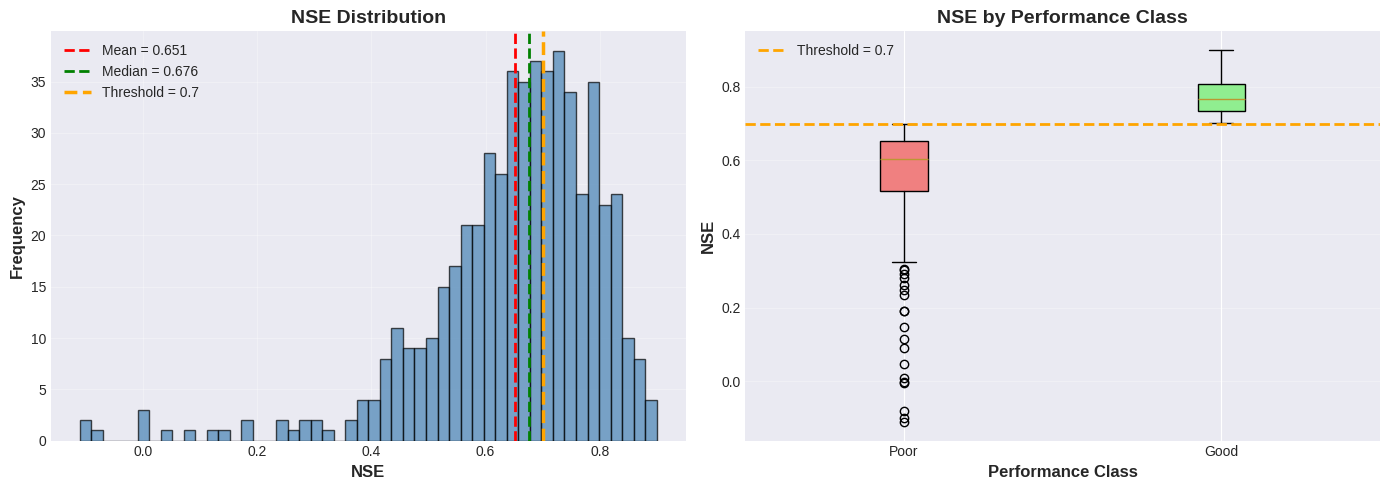

✓ Plot saved: NSE_Distribution_Analysis.pdf

✅ DATA LOADING COMPLETE
Ready for feature extraction with 223 features from 549 stations

Dataset 'data' contains:
  - station_id: Station identifier
  - NSE_val: Target variable (validation NSE)
  - 223 catchment attribute features


In [2]:
# ============================================================
# 1. MOUNT DRIVE & FILE DEFINITIONS
# ============================================================
from google.colab import drive
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount("/content/drive")

# Define data directory
DATA_DIR = Path("/content/drive/MyDrive/Colab Notebooks/Data")

print("="*80)
print("LOADING CAMELS-FR DATA FROM GOOGLE DRIVE")
print("="*80)
print(f"Data directory: {DATA_DIR}")

# ============================================================
# 2. LOAD d-HyMoLAP RESULTS (TARGET VARIABLE)
# ============================================================
hymolap = pd.read_csv(DATA_DIR / 'dHyMoLAP_Simulation_Data_CAMELS_FR.csv')
print(f"\n✓ d-HyMoLAP results loaded: {hymolap.shape}")
print(f"  Stations: {len(hymolap)}")
print(f"  Columns: {list(hymolap.columns)}")

# ============================================================
# 3. LOAD CAMELS-FR ATTRIBUTE FILES
# ============================================================
print(f"\nLoading CAMELS-FR attribute files...")

# Define all files to load (use sep=';' for French CSV format)
attribute_files = {
    'cli': ('CAMELS_FR_climatic_statistics.csv', 'Climatic'),
    'topo': ('CAMELS_FR_topography_general_attributes.csv', 'Topography'),
    'geo': ('CAMELS_FR_geology_attributes.csv', 'Geology'),
    'hgeo': ('CAMELS_FR_hydrogeology_attributes.csv', 'Hydrogeology'),
    'lc': ('CAMELS_FR_land_cover_attributes.csv', 'Land cover'),
    'soil': ('CAMELS_FR_soil_general_attributes.csv', 'Soil'),
    'hydro': ('CAMELS_FR_hydrological_signatures.csv', 'Hydrology'),
    'hclim': ('CAMELS_FR_hydroclimatic_statistics_joint_availability_yearly.csv', 'Hydroclimatic'),
    'human': ('CAMELS_FR_human_influences_dams.csv', 'Human influences'),
    'sta': ('CAMELS_FR_station_general_attributes.csv', 'Station attributes'),
    'site': ('CAMELS_FR_site_general_attributes.csv', 'Site attributes')
}

# Load all files
datasets = {}
for key, (filename, description) in attribute_files.items():
    file_path = DATA_DIR / filename
    df = pd.read_csv(file_path, sep=';')
    datasets[key] = df
    print(f"  {description:25s}: {df.shape[0]:3d} stations × {df.shape[1]:3d} features")

# Unpack datasets
cli = datasets['cli']
topo = datasets['topo']
geo = datasets['geo']
hgeo = datasets['hgeo']
lc = datasets['lc']
soil = datasets['soil']
hydro = datasets['hydro']
hclim = datasets['hclim']
human = datasets['human']
sta = datasets['sta']
site = datasets['site']

print(f"\n✓ All CAMELS-FR files loaded successfully")

# ============================================================
# 4. AGGREGATE SOIL DATA (MULTIPLE DEPTHS → STATION LEVEL)
# ============================================================
print(f"\nAggregating soil data by station...")
print(f"  Soil (raw): {soil.shape[0]} rows × {soil.shape[1]} features")

# Get numeric columns (exclude station ID)
numeric_soil_cols = soil.select_dtypes(include=[np.number]).columns.tolist()
numeric_soil_cols = [c for c in numeric_soil_cols if c != 'sta_code_h3']

# Aggregate by mean across depths
soil_agg = soil.groupby('sta_code_h3')[numeric_soil_cols].mean().reset_index()
print(f"  Soil (aggregated): {soil_agg.shape[0]} stations × {soil_agg.shape[1]} features")

# ============================================================
# 5. MERGE ALL ATTRIBUTE FILES
# ============================================================
print(f"\n{'-'*80}")
print("MERGING ALL ATTRIBUTE FILES")
print("-"*80)

# Start with climatic as base
camels = cli.copy()
print(f"Base (Climatic): {camels.shape[1]-1} features")

# Define merge order
merge_datasets = [
    (topo, 'Topography'),
    (geo, 'Geology'),
    (hgeo, 'Hydrogeology'),
    (lc, 'Land cover'),
    (soil_agg, 'Soil'),
    (hydro, 'Hydrology'),
    (hclim, 'Hydroclimatic'),
    (human, 'Human influences'),
    (sta, 'Station attributes'),
    (site, 'Site attributes')
]

# Merge sequentially
for df, name in merge_datasets:
    before_cols = camels.shape[1]
    camels = camels.merge(df, on='sta_code_h3', how='left')
    after_cols = camels.shape[1]
    added_cols = after_cols - before_cols
    print(f"+ {name:20s}: {added_cols:3d} features added → Total: {after_cols-1:3d} features")

print(f"\n{'='*80}")
print("MERGED CAMELS-FR DATASET")
print("="*80)
print(f"Shape: {camels.shape}")
print(f"Total features: {camels.shape[1] - 1} (excluding station_id)")

# ============================================================
# 6. MERGE WITH d-HyMoLAP RESULTS
# ============================================================
print(f"\nMerging d-HyMoLAP results with CAMELS-FR attributes...")

# Match: hymolap['station_id'] ↔ camels['sta_code_h3']
data = hymolap[['station_id', 'NSE_val']].merge(
    camels,
    left_on='station_id',
    right_on='sta_code_h3',
    how='inner'
)

# Remove duplicate ID column
data = data.drop(columns=['sta_code_h3'])

print(f"\n{'='*80}")
print("FINAL MERGED DATASET")
print("="*80)
print(f"Shape: {data.shape}")
print(f"Stations: {len(data)}")
print(f"Total columns: {data.shape[1]}")
print(f"Feature columns: {data.shape[1] - 2} (excluding station_id and NSE_val)")

# ============================================================
# 7. FEATURE SUMMARY BY CATEGORY
# ============================================================
print(f"\n{'-'*80}")
print("FEATURE SUMMARY BY CATEGORY")
print("-"*80)

feature_prefixes = {
    'cli_': 'Climate',
    'top_': 'Topography',
    'geo_': 'Geology',
    'hgl_': 'Hydrogeology',
    'clc_': 'Land cover',
    'sol_': 'Soil',
    'hyd_': 'Hydrology',
    'hyc_': 'Hydroclimatic',
    'dam_': 'Human influences',
    'sta_': 'Station attributes',
    'sit_': 'Site attributes'
}

for prefix, category in feature_prefixes.items():
    count = sum(1 for col in data.columns if col.startswith(prefix))
    if count > 0:
        print(f"  {category:25s}: {count:3d} features")

# ============================================================
# 8. TARGET VARIABLE ANALYSIS
# ============================================================
print(f"\n{'='*80}")
print("TARGET VARIABLE (NSE_val)")
print("="*80)
print(data['NSE_val'].describe())

# Binary classification analysis
nse_threshold = 0.70
good_count = (data['NSE_val'] > nse_threshold).sum()
poor_count = (data['NSE_val'] <= nse_threshold).sum()

print(f"\nBinary Classification (threshold = {nse_threshold}):")
print(f"  Good (NSE > {nse_threshold}): {good_count:3d} stations ({100*good_count/len(data):4.1f}%)")
print(f"  Poor (NSE ≤ {nse_threshold}): {poor_count:3d} stations ({100*poor_count/len(data):4.1f}%)")

class_ratio = good_count / poor_count if poor_count > 0 else float('inf')
print(f"  Class ratio: {class_ratio:.2f} (balanced: 0.5-2.0)")
if 0.5 <= class_ratio <= 2.0:
    print("  ✅ Classes are reasonably balanced")
else:
    print("  ⚠️  Class imbalance detected")

# ============================================================
# 9. VISUALIZE NSE DISTRIBUTION
# ============================================================
print(f"\n{'-'*80}")
print("Generating NSE distribution plot...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram with statistics
axes[0].hist(data['NSE_val'], bins=50, alpha=0.7, edgecolor='black', color='steelblue')
axes[0].axvline(data['NSE_val'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean = {data["NSE_val"].mean():.3f}')
axes[0].axvline(data['NSE_val'].median(), color='green', linestyle='--', linewidth=2,
                label=f'Median = {data["NSE_val"].median():.3f}')
axes[0].axvline(nse_threshold, color='orange', linestyle='--', linewidth=2.5,
                label=f'Threshold = {nse_threshold}')
axes[0].set_xlabel('NSE', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('NSE Distribution', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Box plot by performance class
box_data = [data[data['NSE_val'] <= nse_threshold]['NSE_val'],
            data[data['NSE_val'] > nse_threshold]['NSE_val']]
bp = axes[1].boxplot(box_data, labels=['Poor', 'Good'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightcoral')
bp['boxes'][1].set_facecolor('lightgreen')
axes[1].axhline(nse_threshold, color='orange', linestyle='--', linewidth=2,
                label=f'Threshold = {nse_threshold}')
axes[1].set_ylabel('NSE', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Performance Class', fontsize=12, fontweight='bold')
axes[1].set_title('NSE by Performance Class', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('NSE_Distribution_Analysis.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot saved: NSE_Distribution_Analysis.pdf")

# ============================================================
# 10. FINAL SUMMARY
# ============================================================
print(f"\n{'='*80}")
print("✅ DATA LOADING COMPLETE")
print("="*80)
print(f"Ready for feature extraction with {data.shape[1]-2} features from {len(data)} stations")
print(f"\nDataset 'data' contains:")
print(f"  - station_id: Station identifier")
print(f"  - NSE_val: Target variable (validation NSE)")
print(f"  - {data.shape[1]-2} catchment attribute features")

---
## 3. Feature Engineering


In [3]:
# ============================================================================
# FEATURE GROUPS - COMPLETE HYDROLOGICALLY INFORMED SELECTION
# ============================================================================

feature_groups = {

    # ========================================================================
    # CATCHMENT SCALE
    # ========================================================================

    'Catchment_Scale': [
    'sta_area_snap',           # Catchment area [km²] - gauged / SNAP
    'sit_area_hydro',          # Hydrological contributing area [km²] ⭐⭐⭐
    'sit_area_topo',           # Topographic (GIS) catchment area [km²]
    ],

    'Catchment_Geometry': [
        'top_dist_outlet_mean',    # Mean flow path length [km]
        'top_drainage_density',    # Drainage density [km/km²]
        'top_mor_compact_coef',    # Compactness (response time proxy)
        'top_mor_elong_ratio_catchment', # Elongation ratio
    ],

    # ========================================================================
    # CLIMATE FORCING
    # ========================================================================

    'Precipitation_Amount': [
        'cli_prec_mean',           # Mean annual precipitation [mm/yr]
        'hyc_jay_prec_mean',       # Joint availability precipitation [mm/yr]
        'cli_prec_intensity',      # Precipitation intensity [mm/day]
        'cli_prec_max',            # Maximum daily precipitation [mm/day]
    ],

    'Precipitation_Timing': [
        'cli_prec_season_temp',    # Precipitation seasonality vs temperature
        'cli_prec_season_pet_ou',  # Precipitation seasonality vs PET
        'cli_prec_freq_high',      # High precip frequency [days/yr]
        'cli_prec_dur_high',       # High precip duration [days]
        'cli_prec_freq_low',       # Low precip frequency [days/yr]
        'cli_prec_dur_low',        # Low precip duration [days]
    ],

    'PET_Evaporation': [
        'cli_pet_ou_mean',         # PET Oudin [mm/yr]
        'cli_pet_pm_mean',         # PET Penman-Monteith [mm/yr]
        'cli_pet_pe_mean',         # PET Priestley-Taylor [mm/yr]
    ],

    'Water_Balance': [
        'cli_aridity_ou',          # Aridity index (PET/P) - Oudin
        'cli_aridity_pm',          # Aridity index (PET/P) - Penman-Monteith
        'hyc_jay_ratio_prec_pet_ou', # P/PET ratio
        'hyc_jay_ratio_q_prec',    # Runoff ratio (Q/P)
    ],

    'Climate_Seasonality': [
        'cli_assync_ou',           # Climate asynchrony (P-PET phase shift)
        'cli_assync_pm',           # Climate asynchrony (alternative)
        'cli_psol_frac_safran',    # Snow fraction (SAFRAN)
        'cli_psol_frac_berghuijs', # Snow fraction (Berghuijs)
    ],

    'Temperature': [
        'cli_temp_mean',           # Mean annual temperature [°C]
    ],

    # ========================================================================
    # FLOW REGIME CHARACTERISTICS
    # ========================================================================

    'Baseflow_Storage': [
        'hyd_bfi_ladson',          # Baseflow index (Ladson)
        'hyd_bfi_lfstat',          # Baseflow index (lfstat)
        'hyd_bfi_pelletier_pet_ou', # Baseflow index (Pelletier)
    ],

    'Flow_Magnitude': [
        'hyd_q_mean',              # Mean discharge [mm/day]
        'hyd_q_max',               # Maximum discharge [mm/day]
        'hyd_q_qmna_min',          # Minimum annual discharge [mm/day]
    ],

    'Flow_Variability': [
        'hyd_slope_fdc',           # Flow duration curve slope
        'hyd_stream_elas',         # Streamflow elasticity
        'hyd_hfd_mean',            # Half flow date [day of year]
    ],

    'Flow_Extremes_High': [
        'hyd_q_freq_high',         # High flow frequency [days/yr]
        'hyd_q_dur_high',          # High flow duration [days]
    ],

    'Flow_Extremes_Low': [
        'hyd_q_freq_low',          # Low flow frequency [days/yr]
        'hyd_q_dur_low',           # Low flow duration [days]
        'hyd_q_freq_zero',         # Zero flow frequency [days/yr]
    ],

    # ========================================================================
    # LANDSCAPE CHARACTERISTICS
    # ========================================================================

    'Topography_Elevation': [
        'top_altitude_mean',       # Mean catchment elevation [m]
    ],

    'Topography_Slope': [
        'top_slo_mean',            # Mean slope [%]
        'top_slo_gentle',          # Gentle slope fraction [%]
        'top_slo_steep',           # Steep slope fraction [%]
        'top_slo_very_steep',      # Very steep slope fraction [%]
    ],

    'Topography_Morphology': [
        'top_mor_relief_ratio',    # Relief ratio (Δz / length)
        'top_mor_shape_factor',    # Shape factor
        'top_mor_circ_ratio',      # Circularity ratio
    ],

    'Topography_Aspect': [
        'top_slo_ori_n',           # North-facing slope fraction
        'top_slo_ori_s',           # South-facing slope fraction
    ],

    # ========================================================================
    # SUBSURFACE PROPERTIES
    # ========================================================================

    'Geology_Lithology': [
        'geo_dom_class',           # Dominant geology class (categorical)
        'geo_su',                  # Unconsolidated sediments [%]
        'geo_sc',                  # Carbonate rocks [%]
        'geo_ss',                  # Siliciclastic rocks [%]
        'geo_mt',                  # Metamorphic rocks [%]
    ],

    'Hydrogeology_Aquifer': [
        'hgl_permeability',        # Permeability [log10(m²)]
        'hgl_porosity',            # Porosity [%]
        'hgl_krs_karstic',         # Karst presence [%]
        'hgl_thm_alluvial',        # Alluvial aquifer [%]
        'hgl_thm_bedrock',         # Bedrock aquifer [%]
    ],

    'Soil_Texture': [
        'sol_clay',                # Clay content [%]
        'sol_sand',                # Sand content [%]
        'sol_silt',                # Silt content [%]
    ],

    'Soil_Properties': [
        'sol_depth_to_root',       # Rooting depth [cm]
        'sol_depth_to_bedrock',    # Depth to bedrock [cm]
        'sol_tawc',                # Total available water capacity [mm]
        'sol_conductivity',        # Hydraulic conductivity [cm/day]
        'sol_bd',                  # Bulk density [g/cm³]
        'sol_gravel',              # Gravel content [%]
    ],

    # ========================================================================
    # LAND COVER
    # ========================================================================

    'Landcover_Dominant': [
        'clc_2018_lvl2_dom_class', # Dominant land cover (categorical)
    ],

    'Landcover_Urban': [
        'clc_2018_lvl2_11',        # Continuous urban fabric [%]
        'clc_2018_lvl2_12',        # Discontinuous urban fabric [%]
    ],

    'Landcover_Agriculture': [
        'clc_2018_lvl2_21',        # Arable land [%]
        'clc_2018_lvl2_22',        # Permanent crops [%]
        'clc_2018_lvl2_23',        # Pastures [%]
        'clc_2018_lvl2_24',        # Heterogeneous agricultural [%]
    ],

    'Landcover_Forest': [
        'clc_2018_lvl2_31',        # Forest [%]
        'clc_2018_lvl2_32',        # Shrub/herbaceous [%]
        'clc_2018_lvl2_33',        # Open spaces [%]
    ],

    'Landcover_Wetland_Water': [
        'clc_2018_lvl2_41',        # Wetlands [%]
        'clc_2018_lvl2_51',        # Inland waters [%]
    ],

    # ========================================================================
    # HUMAN INFLUENCES
    # ========================================================================

    'Human_Regulation': [
        'dam_n',                   # Number of dams
        'dam_volume',              # Total dam storage [m³]
        'dam_influence',           # Dam regulation index
    ],
}

# ============================================================================
# DERIVED FEATURES (Computed during preprocessing)
# ============================================================================
derived_features = {
    'log_area': 'np.log10(sta_area_snap + 1)',
    'concentration_time': 'top_dist_outlet_mean / np.sqrt(top_slo_mean + 0.01)',  # Flow path / slope
    'storage_index': 'sol_tawc * sol_depth_to_root',  # Soil storage capacity
    'response_speed': 'top_drainage_density * top_slo_mean',  # Drainage efficiency
}

print("="*80)
print("FEATURE GROUPS - COMPLETE & HYDROLOGICALLY INFORMED")
print("="*80)
print("   1. Catchment area (raw + log) - PRIMARY control")
print("   2. Runoff ratio (Q/P) - Direct NSE predictor")
print("   3. Storage proxies (BFI, soil depth, TWC)")
print("   4. Flow timing (HFD, seasonality)")
print("   5. Extremes (Q_max, Q_min, zero flow)")
print("\n✅ DERIVED FEATURES (computed):")
for name, formula in derived_features.items():
    print(f"   • {name:20s}: {formula}")

print("\n" + "-"*80)
print("Feature Count by Major Category:")
print("-"*80)

categories = {
    'SCALE (⭐ Critical)': ['Catchment_Scale', 'Catchment_Geometry'],
    'Climate': ['Precipitation_Amount', 'Precipitation_Timing', 'PET_Evaporation',
                'Water_Balance', 'Climate_Seasonality', 'Temperature'],
    'Flow Regime': ['Baseflow_Storage', 'Flow_Magnitude', 'Flow_Variability',
                    'Flow_Extremes_High', 'Flow_Extremes_Low'],
    'Topography': ['Topography_Elevation', 'Topography_Slope', 'Topography_Morphology',
                   'Topography_Aspect'],
    'Subsurface': ['Geology_Lithology', 'Hydrogeology_Aquifer', 'Soil_Texture', 'Soil_Properties'],
    'Land Cover': ['Landcover_Dominant', 'Landcover_Urban', 'Landcover_Agriculture',
                   'Landcover_Forest', 'Landcover_Wetland_Water'],
    'Human': ['Human_Regulation']
}

for major_cat, subgroups in categories.items():
    n_features = sum(len(feature_groups[sg]) for sg in subgroups)
    print(f"\n{major_cat} ({len(subgroups)} groups, {n_features} features):")
    for sg in subgroups:
        features = feature_groups[sg]
        n_critical = sum(1 for f in features if '⭐' in str(f))
        mark = " ⭐" if n_critical > 0 else ""
        print(f"  • {sg:30s}: {len(features):2d} features{mark}")

total_features = sum(len(features) for features in feature_groups.values())
total_derived = len(derived_features)

print(f"\n{'='*80}")
print(f"TOTAL: {len(feature_groups)} feature groups")
print(f"       {total_features} base features")
print(f"       {total_derived} derived features")
print(f"       {total_features + total_derived} features ready for extraction")
print(f"{'='*80}")

print("\n" + "="*80)
print("HYDROLOGICAL RATIONALE - COMPLETE")

FEATURE GROUPS - COMPLETE & HYDROLOGICALLY INFORMED
   1. Catchment area (raw + log) - PRIMARY control
   2. Runoff ratio (Q/P) - Direct NSE predictor
   3. Storage proxies (BFI, soil depth, TWC)
   4. Flow timing (HFD, seasonality)
   5. Extremes (Q_max, Q_min, zero flow)

✅ DERIVED FEATURES (computed):
   • log_area            : np.log10(sta_area_snap + 1)
   • concentration_time  : top_dist_outlet_mean / np.sqrt(top_slo_mean + 0.01)
   • storage_index       : sol_tawc * sol_depth_to_root
   • response_speed      : top_drainage_density * top_slo_mean

--------------------------------------------------------------------------------
Feature Count by Major Category:
--------------------------------------------------------------------------------

SCALE (⭐ Critical) (2 groups, 7 features):
  • Catchment_Scale               :  3 features
  • Catchment_Geometry            :  4 features

Climate (6 groups, 22 features):
  • Precipitation_Amount          :  4 features
  • Precipitation_Timin

---
## 4. Feature Extraction and Exclusion

**Critical Data Integrity Step:**
- Exclude target variable (NSE_val, NSE_train)
- Exclude calibrated parameters (MU, LAMBDA, Qs, qs)
- Exclude performance metrics (RMSE)
- Keep only catchment characteristics


In [4]:
# Define features to exclude (prevent data leakage)
exclude_features = [
    # Target variables
    'NSE_val', 'NSE_train',

    # Performance metrics
    'RMSE_val', 'RMSE_train',

    # Calibrated parameters (model outputs)
    'MU', 'LAMBDA', 'Qs', 'qs',

    # Identifiers
    'station_id', 'Performance'
]

print("="*80)
print("FEATURE EXCLUSION (Data Leakage Prevention)")
print("="*80)

# Check which excluded features exist
existing_exclude = [f for f in exclude_features if f in data.columns]
print(f"\nExcluding {len(existing_exclude)} features:")
for i, feat in enumerate(existing_exclude, 1):
    print(f"  {i}. ❌ {feat}")

# Extract all features from groups
all_group_features = []
for group_name, features in feature_groups.items():
    all_group_features.extend(features)

# Get features that exist in data
available_features = [f for f in all_group_features if f in data.columns]
missing_features = [f for f in all_group_features if f not in data.columns]

print(f"\n{'='*80}")
print("FEATURE AVAILABILITY CHECK")
print("="*80)
print(f"Features requested: {len(all_group_features)}")
print(f"Features available: {len(available_features)}")
print(f"Features missing: {len(missing_features)}")

if missing_features:
    print(f"\nMissing features:")
    for feat in missing_features[:10]:
        print(f"  ⚠️  {feat}")
    if len(missing_features) > 10:
        print(f"  ... and {len(missing_features)-10} more")

# Create feature matrix X
X_initial = data[available_features].copy()
y = data['NSE_val'].copy()

print(f"\n{'='*80}")
print("INITIAL FEATURE MATRIX")
print("="*80)
print(f"Shape: {X_initial.shape}")
print(f"Stations: {len(X_initial)}")
print(f"Features: {X_initial.shape[1]}")

# Triple verification
verification_failed = [f for f in exclude_features if f in X_initial.columns]
if verification_failed:
    raise ValueError(f"❌ CRITICAL: Data leakage detected! {verification_failed}")
else:
    print(f"\n✅ VERIFICATION PASSED: No excluded features in X")


FEATURE EXCLUSION (Data Leakage Prevention)

Excluding 2 features:
  1. ❌ NSE_val
  2. ❌ station_id

FEATURE AVAILABILITY CHECK
Features requested: 87
Features available: 87
Features missing: 0

INITIAL FEATURE MATRIX
Shape: (549, 87)
Stations: 549
Features: 87

✅ VERIFICATION PASSED: No excluded features in X


---
## 5. Feature Preprocessing

1. Handle missing values (median imputation)
2. Remove zero-variance features
3. Normalize spatial coordinates
4. Handle categorical variables properly
5. NO NSE-based filtering


In [5]:
# Step 1: Handle missing values
print("="*80)
print("FEATURE PREPROCESSING")
print("="*80)

missing_before = X_initial.isnull().sum().sum()
print(f"\nMissing values before: {missing_before}")

# Identify numeric and categorical columns
numeric_cols = X_initial.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_initial.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numeric features: {len(numeric_cols)}")
print(f"Categorical features: {len(categorical_cols)}")

# Impute numeric features with median (robust)
X_numeric = X_initial[numeric_cols].fillna(X_initial[numeric_cols].median())

# Handle categorical features
if len(categorical_cols) > 0:
    X_categorical = X_initial[categorical_cols].fillna('Unknown')
    X_processed = pd.concat([X_numeric, X_categorical], axis=1)
else:
    X_processed = X_numeric.copy()

missing_after = X_processed.isnull().sum().sum()
print(f"Missing values after: {missing_after}")

if missing_after == 0:
    print("✅ All missing values handled")

# Step 2: Remove zero-variance features
print(f"\n{'-'*80}")
print("ZERO-VARIANCE REMOVAL")
print("-"*80)

variances = X_processed[numeric_cols].var()
zero_var = variances[variances == 0].index.tolist()

if len(zero_var) > 0:
    print(f"Removing {len(zero_var)} zero-variance features:")
    for feat in zero_var:
        print(f"  ❌ {feat}")
    X_processed = X_processed.drop(columns=zero_var)
else:
    print("✅ No zero-variance features found")

# Step 3: Normalize spatial coordinates (EXPERT RECOMMENDATION 3)
print(f"\n{'-'*80}")
print("SPATIAL FEATURE NORMALIZATION (Recommendation 3)")
print("-"*80)

if 'sta_x_w84' in X_processed.columns and 'sta_y_w84' in X_processed.columns:
    # Normalize coordinates
    X_processed['lon_norm'] = (X_processed['sta_x_w84'] - X_processed['sta_x_w84'].mean()) / X_processed['sta_x_w84'].std()
    X_processed['lat_norm'] = (X_processed['sta_y_w84'] - X_processed['sta_y_w84'].mean()) / X_processed['sta_y_w84'].std()

    # Remove original coordinates
    X_processed = X_processed.drop(columns=['sta_x_w84', 'sta_y_w84'])

    print("✅ Spatial coordinates normalized:")
    print("   lon_norm = (longitude - mean) / std")
    print("   lat_norm = (latitude - mean) / std")
    print("   → XGBoost can now learn smooth spatial effects")
else:
    print("⚠️  Spatial coordinates not found")

# Step 4: Handle categorical variables properly
print(f"\n{'-'*80}")
print("CATEGORICAL ENCODING")
print("-"*80)

categorical_in_processed = X_processed.select_dtypes(include=['object', 'category']).columns.tolist()

if len(categorical_in_processed) > 0:
    print(f"Encoding {len(categorical_in_processed)} categorical features:")
    for feat in categorical_in_processed:
        print(f"  → {feat}")

    # One-hot encoding (drop_first to avoid multicollinearity)
    X_processed = pd.get_dummies(X_processed, columns=categorical_in_processed, drop_first=True)
    print(f"\n✅ Categorical features encoded")
else:
    print("✅ No categorical features to encode")

print(f"\n{'='*80}")
print("FINAL PREPROCESSED FEATURES")
print("="*80)
print(f"Shape: {X_processed.shape}")
print(f"Features: {X_processed.shape[1]}")
print(f"Samples: {len(X_processed)}")

# Store for model training
X = X_processed.copy()
feature_names = X.columns.tolist()

print(f"\n✅ Preprocessing complete")
print(f"   Final feature count: {len(feature_names)}")


FEATURE PREPROCESSING

Missing values before: 1161
Numeric features: 86
Categorical features: 1
Missing values after: 1098

--------------------------------------------------------------------------------
ZERO-VARIANCE REMOVAL
--------------------------------------------------------------------------------
✅ No zero-variance features found

--------------------------------------------------------------------------------
SPATIAL FEATURE NORMALIZATION (Recommendation 3)
--------------------------------------------------------------------------------
⚠️  Spatial coordinates not found

--------------------------------------------------------------------------------
CATEGORICAL ENCODING
--------------------------------------------------------------------------------
Encoding 1 categorical features:
  → geo_dom_class

✅ Categorical features encoded

FINAL PREPROCESSED FEATURES
Shape: (549, 93)
Features: 93
Samples: 549

✅ Preprocessing complete
   Final feature count: 93


---
## Feature Sanity Filtering

1. Remove near-constant features (variance ≤ 1e-4)
2. Remove quasi-duplicates (correlation > 0.98)


In [6]:
print("="*80)
print("FEATURE SANITY FILTERING")
print("="*80)

# STEP 1.1: Remove near-constant features
print(f"\nStep 1: Remove near-constant features")
var_thresh = 1e-4
variances = X.var()
low_var = variances[variances <= var_thresh].index.tolist()

if len(low_var) > 0:
    print(f"  Removing {len(low_var)} features with variance ≤ {var_thresh}")
    X = X.drop(columns=low_var)
else:
    print(f"  ✓ No near-constant features found")

print(f"  Features after variance filter: {X.shape[1]}")

# STEP 1.2: Remove quasi-duplicates
print(f"\nStep 2: Remove highly correlated features (|r| > 0.98)")
corr = X.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [c for c in upper.columns if any(upper[c] > 0.98)]

if len(to_drop) > 0:
    print(f"  Removing {len(to_drop)} quasi-duplicate features:")
    for i, feat in enumerate(to_drop[:10], 1):
        corr_with = upper[feat][upper[feat] > 0.98].index[0]
        print(f"    {i:2d}. {feat} ↔ {corr_with}")
    if len(to_drop) > 10:
        print(f"    ... and {len(to_drop)-10} more")
    X = X.drop(columns=to_drop)
else:
    print(f"  ✓ No highly correlated features found")

print(f"\n{'='*80}")
print(f"FINAL: {X.shape[1]} features after sanity filtering")
print(f"{'='*80}")

# Update feature names
feature_names = X.columns.tolist()


FEATURE SANITY FILTERING

Step 1: Remove near-constant features
  ✓ No near-constant features found
  Features after variance filter: 93

Step 2: Remove highly correlated features (|r| > 0.98)
  Removing 4 quasi-duplicate features:
     1. hyc_jay_prec_mean ↔ cli_prec_mean
     2. cli_assync_pm ↔ cli_assync_ou
     3. hyd_bfi_lfstat ↔ hyd_bfi_ladson
     4. dam_volume ↔ sta_area_snap

FINAL: 89 features after sanity filtering


#**PART 1: Setup & Configuration**

In [7]:
# ============================================================================
# FEATURE SELECTION WITH SHAP CONSENSUS
# ============================================================================
# Methodology:
# 1. Conservative hyperparameters for generalization
# 2. Stratified 5-fold CV for balanced evaluation
# 3. Per-fold SHAP computation for stability
# 4. Cross-model consensus (RF + XGBoost)
# 5. Directional SHAP for hydrological interpretation
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, balanced_accuracy_score, recall_score
import shap

# Configuration
N_FOLDS = 5
RANDOM_SEED = 42
TOP_N = 40  # Top features per model for consensus
FINAL_N = 20  # Final consensus features

print("="*80)
print("EXPERT FEATURE SELECTION PIPELINE")
print("="*80)
print(f"\nConfiguration:")
print(f"  Cross-validation: {N_FOLDS}-fold stratified")
print(f"  Random seed: {RANDOM_SEED}")
print(f"  Top features per model: {TOP_N}")
print(f"  Final consensus features: {FINAL_N}")
print(f"  Target: Binary (NSE > 0.70)")

EXPERT FEATURE SELECTION PIPELINE

Configuration:
  Cross-validation: 5-fold stratified
  Random seed: 42
  Top features per model: 40
  Final consensus features: 20
  Target: Binary (NSE > 0.70)


# **PART 2: Stratified CV Setup**

In [8]:
# ============================================================================
# STEP 1 & 2: STRATIFIED CROSS-VALIDATION SETUP
# ============================================================================

print("\n" + "="*80)
print("STRATIFIED CROSS-VALIDATION SETUP")
print("="*80)

# Create binary target for stratification
y_binary = (data['NSE_val'] > 0.70).astype(int)

# Stratified CV splitter
cv_splitter = StratifiedKFold(
    n_splits=N_FOLDS,
    shuffle=True,
    random_state=RANDOM_SEED
)

print(f"\nTarget distribution:")
print(f"  Good (NSE > 0.70): {sum(y_binary == 1)} ({100*sum(y_binary == 1)/len(y_binary):.1f}%)")
print(f"  Poor (NSE <= 0.70): {sum(y_binary == 0)} ({100*sum(y_binary == 0)/len(y_binary):.1f}%)")

# Verify stratification
print(f"\nFold-wise class distribution:")
for fold_idx, (train_idx, val_idx) in enumerate(cv_splitter.split(X, y_binary), 1):
    y_train = y_binary.iloc[train_idx]
    y_val = y_binary.iloc[val_idx]
    print(f"  Fold {fold_idx}: Train Good={sum(y_train==1):3d}/{len(y_train):3d} ({100*sum(y_train==1)/len(y_train):.1f}%) | "
          f"Val Good={sum(y_val==1):3d}/{len(y_val):3d} ({100*sum(y_val==1)/len(y_val):.1f}%)")

print(f"\n✅ Stratified CV configured")


STRATIFIED CROSS-VALIDATION SETUP

Target distribution:
  Good (NSE > 0.70): 235 (42.8%)
  Poor (NSE <= 0.70): 314 (57.2%)

Fold-wise class distribution:
  Fold 1: Train Good=188/439 (42.8%) | Val Good= 47/110 (42.7%)
  Fold 2: Train Good=188/439 (42.8%) | Val Good= 47/110 (42.7%)
  Fold 3: Train Good=188/439 (42.8%) | Val Good= 47/110 (42.7%)
  Fold 4: Train Good=188/439 (42.8%) | Val Good= 47/110 (42.7%)
  Fold 5: Train Good=188/440 (42.7%) | Val Good= 47/109 (43.1%)

✅ Stratified CV configured


# **PART 3: Random Forest with Per-Fold SHAP**

In [9]:
# ============================================================================
# STEP 3-5: RANDOM FOREST - CONSERVATIVE HYPERPARAMETERS + PER-FOLD SHAP
# ============================================================================

print("\n" + "="*80)
print("RANDOM FOREST - STABILITY EXTRACTOR")
print("="*80)

# Conservative hyperparameters
rf_params = {
    'n_estimators': 1000,        # Adequate trees
    'max_depth': 6,             # Moderate depth
    'min_samples_leaf': 10,     # Conservative leaves
    'max_features': 'sqrt',     # Feature subsampling
    'class_weight': 'balanced', # Handle imbalance
    'random_state': RANDOM_SEED,
    'n_jobs': -1,
    'verbose': 0
}

print("\nConservative hyperparameters:")
for key, val in rf_params.items():
    print(f"  {key:20s}: {val}")

# Storage for per-fold SHAP
rf_shap_folds = []
rf_performance = []

print(f"\n{'='*60}")
print(f"Training RF across {N_FOLDS} folds with per-fold SHAP...")
print("="*60)

#  Stratified CV with per-fold SHAP
for fold_idx, (train_idx, val_idx) in enumerate(cv_splitter.split(X, y_binary), 1):
    print(f"\nFold {fold_idx}/{N_FOLDS}:")

    # Get fold data
    X_train_fold = X.iloc[train_idx]
    X_val_fold = X.iloc[val_idx]
    y_train_fold = y_binary.iloc[train_idx]
    y_val_fold = y_binary.iloc[val_idx]

    # Train RF
    rf_model = RandomForestClassifier(**rf_params)
    rf_model.fit(X_train_fold, y_train_fold)

    # Evaluate
    y_pred = rf_model.predict(X_val_fold)
    f1 = f1_score(y_val_fold, y_pred, average='weighted')
    bal_acc = balanced_accuracy_score(y_val_fold, y_pred)
    recall = recall_score(y_val_fold, y_pred, pos_label=1)

    rf_performance.append({
        'fold': fold_idx,
        'f1': f1,
        'balanced_acc': bal_acc,
        'recall_good': recall
    })

    print(f"  Performance: F1={f1:.4f}, Bal_Acc={bal_acc:.4f}, Recall={recall:.4f}")

    # Compute SHAP for this fold
    print(f"  Computing SHAP values...")
    explainer_rf = shap.TreeExplainer(rf_model)
    shap_values_raw = explainer_rf.shap_values(X_val_fold)

    # Extract Good class (class 1) SHAP values
    shap_values_for_class_1 = None
    if isinstance(shap_values_raw, list):
        # This is the typical output for scikit-learn multi-class models
        # Each element in the list is (n_samples, n_features)
        shap_values_for_class_1 = shap_values_raw[1] # Take SHAP values for class 1 (Good NSE)
    elif isinstance(shap_values_raw, np.ndarray) and shap_values_raw.ndim == 3:
        # This happens for some SHAP versions/models where output is (n_samples, n_features, n_classes)
        # Select SHAP values for class 1
        shap_values_for_class_1 = shap_values_raw[:, :, 1]
    else:
        # Fallback or error if neither of the above
        raise ValueError(f"Unexpected SHAP values format: type={type(shap_values_raw)}, shape={shap_values_raw.shape}")

    print(f"  Shape of SHAP values for class 1 before mean: {shap_values_for_class_1.shape}")

    # Mean absolute SHAP per feature
    # At this point, shap_values_for_class_1 should be (n_samples, n_features)
    mean_abs_shap = np.abs(shap_values_for_class_1).mean(axis=0)
    rf_shap_folds.append(mean_abs_shap)

    print(f"  ✓ SHAP computed")

# Aggregate |SHAP| across folds
rf_shap_matrix = np.vstack(rf_shap_folds)
rf_shap_mean = rf_shap_matrix.mean(axis=0)
rf_shap_std = rf_shap_matrix.std(axis=0)

# Create RF importance DataFrame
rf_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'RF_SHAP_mean': rf_shap_mean,
    'RF_SHAP_std': rf_shap_std,
    'RF_SHAP_CV': rf_shap_std / (rf_shap_mean + 1e-10)
}).sort_values('RF_SHAP_mean', ascending=False).reset_index(drop=True)

# Rank features
rf_importance_df['RF_Rank'] = rf_importance_df['RF_SHAP_mean'].rank(ascending=False)

print(f"\n{'='*80}")
print("RANDOM FOREST RESULTS")
print("="*80)

rf_perf_df = pd.DataFrame(rf_performance)
print(f"\nCross-Validation Performance:")
print(f"  Mean F1: {rf_perf_df['f1'].mean():.4f} ± {rf_perf_df['f1'].std():.4f}")
print(f"  Mean Balanced Acc: {rf_perf_df['balanced_acc'].mean():.4f} ± {rf_perf_df['balanced_acc'].std():.4f}")
print(f"  Mean Recall (Good): {rf_perf_df['recall_good'].mean():.4f} ± {rf_perf_df['recall_good'].std():.4f}")

print(f"\nTop {TOP_N} Features by Mean |SHAP|:")
print("-"*80)
for i, row in rf_importance_df.head(TOP_N).iterrows():
    print(f"  {int(row['RF_Rank']):3d}. {row['Feature']:45s} {row['RF_SHAP_mean']:.6f} ± {row['RF_SHAP_std']:.6f}")

print(f"\n✅ Random Forest complete")


RANDOM FOREST - STABILITY EXTRACTOR

Conservative hyperparameters:
  n_estimators        : 1000
  max_depth           : 6
  min_samples_leaf    : 10
  max_features        : sqrt
  class_weight        : balanced
  random_state        : 42
  n_jobs              : -1
  verbose             : 0

Training RF across 5 folds with per-fold SHAP...

Fold 1/5:
  Performance: F1=0.8005, Bal_Acc=0.7984, Recall=0.7872
  Computing SHAP values...
  Shape of SHAP values for class 1 before mean: (110, 89)
  ✓ SHAP computed

Fold 2/5:
  Performance: F1=0.9088, Bal_Acc=0.9044, Recall=0.8723
  Computing SHAP values...
  Shape of SHAP values for class 1 before mean: (110, 89)
  ✓ SHAP computed

Fold 3/5:
  Performance: F1=0.8082, Bal_Acc=0.8009, Recall=0.7447
  Computing SHAP values...
  Shape of SHAP values for class 1 before mean: (110, 89)
  ✓ SHAP computed

Fold 4/5:
  Performance: F1=0.8641, Bal_Acc=0.8647, Recall=0.8723
  Computing SHAP values...
  Shape of SHAP values for class 1 before mean: (110, 

# **PART 4: XGBoost with Per-Fold SHAP**


In [10]:
# ============================================================================
# STEP 3-5: XGBOOST - CONSERVATIVE HYPERPARAMETERS + PER-FOLD SHAP
# ============================================================================

print("\n" + "="*80)
print("XGBOOST - DISCRIMINATIVE EXTRACTOR")
print("="*80)

# INSTRUCTION 1: Conservative hyperparameters
xgb_params = {
    'n_estimators': 1000,
    'max_depth': 6,                # Conservative depth
    'learning_rate': 0.01,         # Moderate learning rate
    'subsample': 0.8,              # Row subsampling
    'colsample_bytree': 0.8,       # Column subsampling
    'min_child_weight': 10,        # Conservative leaves
    'gamma': 1.0,                  # Pruning
    'reg_lambda': 1.5,             # L2 regularization
    'reg_alpha': 0.5,              # L1 regularization
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': RANDOM_SEED,
    'n_jobs': -1,
    'verbosity': 0
}

print("\nConservative hyperparameters:")
for key, val in xgb_params.items():
    print(f"  {key:20s}: {val}")

# Storage for per-fold SHAP
xgb_shap_folds = []
xgb_performance = []

print(f"\n{'='*60}")
print(f"Training XGBoost across {N_FOLDS} folds with per-fold SHAP...")
print("="*60)

#  Stratified CV with per-fold SHAP
for fold_idx, (train_idx, val_idx) in enumerate(cv_splitter.split(X, y_binary), 1):
    print(f"\nFold {fold_idx}/{N_FOLDS}:")

    # Get fold data
    X_train_fold = X.iloc[train_idx]
    X_val_fold = X.iloc[val_idx]
    y_train_fold = y_binary.iloc[train_idx]
    y_val_fold = y_binary.iloc[val_idx]

    # Train XGBoost
    xgb_model = xgb.XGBClassifier(**xgb_params)
    xgb_model.fit(X_train_fold, y_train_fold, verbose=False)

    # Evaluate
    y_pred = xgb_model.predict(X_val_fold)
    f1 = f1_score(y_val_fold, y_pred, average='weighted')
    bal_acc = balanced_accuracy_score(y_val_fold, y_pred)
    recall = recall_score(y_val_fold, y_pred, pos_label=1)

    xgb_performance.append({
        'fold': fold_idx,
        'f1': f1,
        'balanced_acc': bal_acc,
        'recall_good': recall
    })

    print(f"  Performance: F1={f1:.4f}, Bal_Acc={bal_acc:.4f}, Recall={recall:.4f}")

    # Compute SHAP for this fold
    print(f"  Computing SHAP values...")
    explainer_xgb = shap.TreeExplainer(xgb_model)
    shap_values_fold = explainer_xgb.shap_values(X_val_fold)

    # Mean absolute SHAP per feature
    mean_abs_shap = np.abs(shap_values_fold).mean(axis=0)
    xgb_shap_folds.append(mean_abs_shap)

    print(f"  ✓ SHAP computed")

# Aggregate |SHAP| across folds
xgb_shap_matrix = np.vstack(xgb_shap_folds)
xgb_shap_mean = xgb_shap_matrix.mean(axis=0)
xgb_shap_std = xgb_shap_matrix.std(axis=0)

# Create XGBoost importance DataFrame
xgb_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'XGB_SHAP_mean': xgb_shap_mean,
    'XGB_SHAP_std': xgb_shap_std,
    'XGB_SHAP_CV': xgb_shap_std / (xgb_shap_mean + 1e-10)
}).sort_values('XGB_SHAP_mean', ascending=False).reset_index(drop=True)

#  Rank features
xgb_importance_df['XGB_Rank'] = xgb_importance_df['XGB_SHAP_mean'].rank(ascending=False)

print(f"\n{'='*80}")
print("XGBOOST RESULTS")
print("="*80)

xgb_perf_df = pd.DataFrame(xgb_performance)
print(f"\nCross-Validation Performance:")
print(f"  Mean F1: {xgb_perf_df['f1'].mean():.4f} ± {xgb_perf_df['f1'].std():.4f}")
print(f"  Mean Balanced Acc: {xgb_perf_df['balanced_acc'].mean():.4f} ± {xgb_perf_df['balanced_acc'].std():.4f}")
print(f"  Mean Recall (Good): {xgb_perf_df['recall_good'].mean():.4f} ± {xgb_perf_df['recall_good'].std():.4f}")

print(f"\nTop {TOP_N} Features by Mean |SHAP|:")
print("-"*80)
for i, row in xgb_importance_df.head(TOP_N).iterrows():
    print(f"  {int(row['XGB_Rank']):3d}. {row['Feature']:45s} {row['XGB_SHAP_mean']:.6f} ± {row['XGB_SHAP_std']:.6f}")

print(f"\n✅ XGBoost complete")


XGBOOST - DISCRIMINATIVE EXTRACTOR

Conservative hyperparameters:
  n_estimators        : 1000
  max_depth           : 6
  learning_rate       : 0.01
  subsample           : 0.8
  colsample_bytree    : 0.8
  min_child_weight    : 10
  gamma               : 1.0
  reg_lambda          : 1.5
  reg_alpha           : 0.5
  objective           : binary:logistic
  eval_metric         : logloss
  random_state        : 42
  n_jobs              : -1
  verbosity           : 0

Training XGBoost across 5 folds with per-fold SHAP...

Fold 1/5:
  Performance: F1=0.7906, Bal_Acc=0.7850, Recall=0.7447
  Computing SHAP values...
  ✓ SHAP computed

Fold 2/5:
  Performance: F1=0.8902, Bal_Acc=0.8831, Recall=0.8298
  Computing SHAP values...
  ✓ SHAP computed

Fold 3/5:
  Performance: F1=0.8345, Bal_Acc=0.8247, Recall=0.7447
  Computing SHAP values...
  ✓ SHAP computed

Fold 4/5:
  Performance: F1=0.8000, Bal_Acc=0.7957, Recall=0.7660
  Computing SHAP values...
  ✓ SHAP computed

Fold 5/5:
  Performance: F

# **PART 5: Consensus Selection**

In [11]:
# ============================================================================
# STEP 6-8: CONSENSUS FEATURE SELECTION
# ============================================================================

print("\n" + "="*80)
print("CONSENSUS FEATURE SELECTION (RF + XGBoost)")
print("="*80)

# Get top 40 from each model
rf_top40 = set(rf_importance_df.head(TOP_N)['Feature'].tolist())
xgb_top40 = set(xgb_importance_df.head(TOP_N)['Feature'].tolist())

# Features in BOTH top 40 lists
consensus_features = rf_top40.intersection(xgb_top40)

print(f"\nConsensus analysis:")
print(f"  RF top {TOP_N}: {len(rf_top40)} features")
print(f"  XGBoost top {TOP_N}: {len(xgb_top40)} features")
print(f"  Appearing in BOTH: {len(consensus_features)} features")

# Compute mean rank for ordering
consensus_df = rf_importance_df[rf_importance_df['Feature'].isin(consensus_features)][
    ['Feature', 'RF_SHAP_mean', 'RF_Rank']
].merge(
    xgb_importance_df[xgb_importance_df['Feature'].isin(consensus_features)][
        ['Feature', 'XGB_SHAP_mean', 'XGB_Rank']
    ],
    on='Feature'
)

# Mean rank across both models
consensus_df['Mean_Rank'] = (consensus_df['RF_Rank'] + consensus_df['XGB_Rank']) / 2
consensus_df = consensus_df.sort_values('Mean_Rank').reset_index(drop=True)

# Select top features by mean rank
final_features = consensus_df.head(FINAL_N)['Feature'].tolist()

print(f"\n{'='*80}")
print(f"TOP {FINAL_N} CONSENSUS FEATURES (Ordered by Mean Rank)")
print("="*80)
print(f"{'Rank':>4s} {'Feature':40s} {'RF_Rank':>8s} {'XGB_Rank':>8s} {'Mean_Rank':>10s}")
print("-"*80)

for i, row in consensus_df.head(FINAL_N).iterrows():
    print(f"{i+1:4d} {row['Feature']:40s} {row['RF_Rank']:8.1f} {row['XGB_Rank']:8.1f} {row['Mean_Rank']:10.2f}")

# Save consensus table
consensus_df.to_csv('Feature_Consensus_RF_XGB.csv', index=False)
print(f"\n✓ Saved: Feature_Consensus_RF_XGB.csv")
print(f"\n✅ {FINAL_N} consensus features selected")


CONSENSUS FEATURE SELECTION (RF + XGBoost)

Consensus analysis:
  RF top 40: 40 features
  XGBoost top 40: 40 features
  Appearing in BOTH: 27 features

TOP 20 CONSENSUS FEATURES (Ordered by Mean Rank)
Rank Feature                                   RF_Rank XGB_Rank  Mean_Rank
--------------------------------------------------------------------------------
   1 cli_prec_freq_low                             1.0      1.0       1.00
   2 cli_prec_season_temp                          2.0      2.0       2.00
   3 cli_prec_intensity                            4.0      4.0       4.00
   4 hyd_hfd_mean                                  6.0      5.0       5.50
   5 cli_prec_freq_high                            3.0     10.0       6.50
   6 hyd_bfi_ladson                                8.0      6.0       7.00
   7 top_slo_gentle                                7.0      8.0       7.50
   8 cli_prec_mean                                11.0     12.0      11.50
   9 hgl_thm_bedrock                     

# **PART 6: Train Final Models**

In [12]:
# ============================================================================
# STEP 9: TRAIN FINAL MODELS ON FULL DATA
# ============================================================================

print("\n" + "="*80)
print("TRAINING FINAL MODELS ON FULL DATA")
print("="*80)

# Random Forest - Final
print("\nTraining final Random Forest...")
rf_final = RandomForestClassifier(**rf_params)
rf_final.fit(X, y_binary)
print("✓ RF trained on all data")

# XGBoost - Final
print("\nTraining final XGBoost...")
xgb_final = xgb.XGBClassifier(**xgb_params)
xgb_final.fit(X, y_binary)
print("✓ XGBoost trained on all data")

print("\n✅ Final models trained")


TRAINING FINAL MODELS ON FULL DATA

Training final Random Forest...
✓ RF trained on all data

Training final XGBoost...
✓ XGBoost trained on all data

✅ Final models trained


# **PART 7: SIGNED SHAP for Interpretation**

In [13]:
# ============================================================================
# STEP 10: COMPUTE SIGNED SHAP VALUES FOR HYDROLOGICAL INTERPRETATION
# ============================================================================

print("\n" + "="*80)
print("SIGNED SHAP VALUES - DIRECTIONAL INTERPRETATION")
print("="*80)

# ============================================================================
# CRITICAL: Feature selection happens BEFORE computing signed SHAP
# 1. Get top 40 from RF and XGBoost (based on CV folds)
# 2. Find intersection (consensus features)
# 3. Rank by mean rank
# 4. Select top FINAL_N features
# 5. THEN compute signed SHAP only on XGBoost for these features
# ============================================================================

print("\nFeature selection process:")
print(f"  1. RF top {TOP_N}: Based on mean |SHAP| across CV folds")
print(f"  2. XGBoost top {TOP_N}: Based on mean |SHAP| across CV folds")
print(f"  3. Consensus: Features in BOTH top {TOP_N}")
print(f"  4. Ranking: By mean rank (RF_Rank + XGB_Rank) / 2")
print(f"  5. Final selection: Top {FINAL_N} by mean rank")

# Get top 40 from each model (already done in Part 5)
rf_top40_features = set(rf_importance_df.head(TOP_N)['Feature'].tolist())
xgb_top40_features = set(xgb_importance_df.head(TOP_N)['Feature'].tolist())

# Intersection: features in BOTH top 40
consensus_features = rf_top40_features.intersection(xgb_top40_features)

print(f"\nConsensus summary:")
print(f"  RF top {TOP_N}: {len(rf_top40_features)} features")
print(f"  XGBoost top {TOP_N}: {len(xgb_top40_features)} features")
print(f"  In BOTH: {len(consensus_features)} features")

# Build consensus table with mean rank
consensus_df = rf_importance_df[rf_importance_df['Feature'].isin(consensus_features)][
    ['Feature', 'RF_SHAP_mean', 'RF_Rank']
].merge(
    xgb_importance_df[xgb_importance_df['Feature'].isin(consensus_features)][
        ['Feature', 'XGB_SHAP_mean', 'XGB_Rank']
    ],
    on='Feature'
)

# Compute mean rank
consensus_df['Mean_Rank'] = (consensus_df['RF_Rank'] + consensus_df['XGB_Rank']) / 2
consensus_df = consensus_df.sort_values('Mean_Rank').reset_index(drop=True)

# Select FINAL_N features by mean rank
final_features = consensus_df.head(FINAL_N)['Feature'].tolist()

print(f"\n✅ Selected {len(final_features)} final features by mean rank")

# ============================================================================
# NOW compute signed SHAP for XGBoost on the selected features
# ============================================================================

print(f"\n{'='*80}")
print("Computing SIGNED SHAP for selected consensus features...")
print("="*80)

# Compute SIGNED SHAP on full dataset using final XGBoost model
explainer_final = shap.TreeExplainer(xgb_final)
shap_values_signed = explainer_final.shap_values(X)

print(f"✓ SIGNED SHAP computed for {len(X)} samples × {X.shape[1]} features")

# Extract SHAP values for FINAL_N consensus features only
final_feature_indices = [X.columns.get_loc(f) for f in final_features]
shap_values_final = shap_values_signed[:, final_feature_indices]

# Aggregate SIGNED SHAP (mean, not absolute) for final features
signed_shap_mean = shap_values_final.mean(axis=0)
signed_shap_std = shap_values_final.std(axis=0)

# Create signed SHAP DataFrame for final features
signed_shap_df = pd.DataFrame({
    'Feature': final_features,
    'SHAP_Signed_Mean': signed_shap_mean,
    'SHAP_Signed_Std': signed_shap_std,
    'Direction': np.where(signed_shap_mean > 0, 'Positive', 'Negative')
})

# Merge with consensus table to preserve mean rank order
signed_shap_consensus = consensus_df[consensus_df['Feature'].isin(final_features)][
    ['Feature', 'Mean_Rank', 'RF_Rank', 'XGB_Rank']
].merge(
    signed_shap_df,
    on='Feature'
).sort_values('Mean_Rank')

# ============================================================================
# Display results
# ============================================================================

print(f"\n{'='*80}")
print(f"SIGNED SHAP FOR TOP {FINAL_N} CONSENSUS FEATURES")
print(f"(Ordered by Mean Rank from RF + XGBoost)")
print("="*80)
print(f"{'Rank':>4s} {'Feature':40s} {'RF':>6s} {'XGB':>6s} {'Mean':>6s} {'Signed_SHAP':>12s} {'Dir':>5s}")
print("-"*80)

for _, row in signed_shap_consensus.iterrows():
    direction_symbol = "↑" if row['Direction'] == 'Positive' else "↓"
    print(f"{int(row['Mean_Rank']):4.0f} {row['Feature']:40s} "
          f"{row['RF_Rank']:6.0f} {row['XGB_Rank']:6.0f} {row['Mean_Rank']:6.1f} "
          f"{row['SHAP_Signed_Mean']:+12.6f} {direction_symbol:>5s}")

# Save results
signed_shap_consensus.to_csv('SHAP_Signed_Interpretation.csv', index=False)
print(f"\n✓ Saved: SHAP_Signed_Interpretation.csv")

# Also save full consensus table (for reference)
consensus_df.to_csv('Feature_Consensus_RF_XGB.csv', index=False)
print(f"✓ Saved: Feature_Consensus_RF_XGB.csv")

print(f"\n{'='*80}")
print("✅ DIRECTIONAL SHAP INTERPRETATION READY")
print("="*80)
print(f"\nSummary:")
print(f"  • Consensus features: {len(consensus_features)} (in both top {TOP_N})")
print(f"  • Final selection: {FINAL_N} features by mean rank")
print(f"  • Positive effects: {sum(signed_shap_consensus['Direction']=='Positive')}")
print(f"  • Negative effects: {sum(signed_shap_consensus['Direction']=='Negative')}")
print(f"  • Signed SHAP computed using XGBoost only")


SIGNED SHAP VALUES - DIRECTIONAL INTERPRETATION

Feature selection process:
  1. RF top 40: Based on mean |SHAP| across CV folds
  2. XGBoost top 40: Based on mean |SHAP| across CV folds
  3. Consensus: Features in BOTH top 40
  4. Ranking: By mean rank (RF_Rank + XGB_Rank) / 2
  5. Final selection: Top 20 by mean rank

Consensus summary:
  RF top 40: 40 features
  XGBoost top 40: 40 features
  In BOTH: 27 features

✅ Selected 20 final features by mean rank

Computing SIGNED SHAP for selected consensus features...
✓ SIGNED SHAP computed for 549 samples × 89 features

SIGNED SHAP FOR TOP 20 CONSENSUS FEATURES
(Ordered by Mean Rank from RF + XGBoost)
Rank Feature                                      RF    XGB   Mean  Signed_SHAP   Dir
--------------------------------------------------------------------------------
   1 cli_prec_freq_low                             1      1    1.0    -0.017678     ↓
   2 cli_prec_season_temp                          2      2    2.0    +0.008939     ↑
   

**Plot SHAP**


GENERATING SHAP SUMMARY PLOT (JOURNAL STANDARD)

TOP 20 FEATURES IN TABLE ORDER (by Mean_Rank):
Position   Mean_Rank  Feature
--------------------------------------------------------------------------------
       1         1.0  cli_prec_freq_low
       2         2.0  cli_prec_season_temp
       3         4.0  cli_prec_intensity
       4         5.5  hyd_hfd_mean
       5         6.5  cli_prec_freq_high
       6         7.0  hyd_bfi_ladson
       7         7.5  top_slo_gentle
       8        11.5  cli_prec_mean
       9        12.0  hgl_thm_bedrock
      10        13.5  cli_assync_ou
      11        14.0  hyd_q_max
      12        14.5  sol_gravel
      13        16.0  hyd_q_mean
      14        18.5  hyd_q_freq_high
      15        20.0  hyc_jay_ratio_q_prec
      16        20.5  hyd_bfi_pelletier_pet_ou
      17        21.0  cli_prec_dur_high
      18        22.0  clc_2018_lvl2_11
      19        23.5  top_dist_outlet_mean
      20        23.5  sol_tawc

✓ SHAP values shape: (549, 2

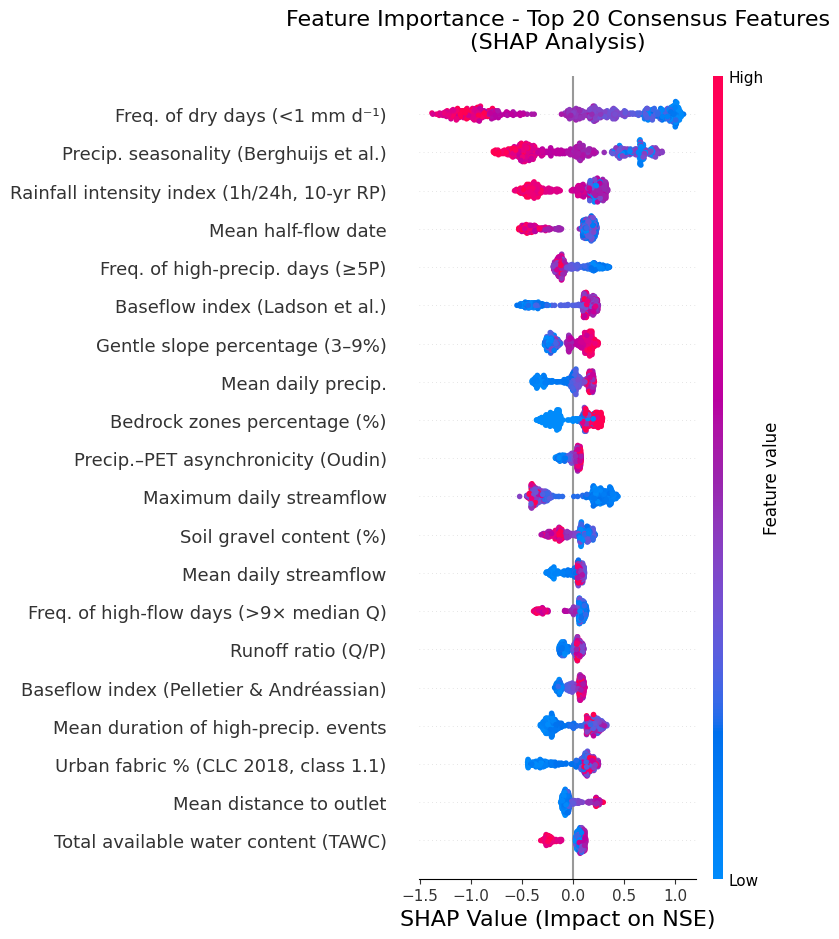


✅ SHAP SUMMARY PLOT SAVED (CONSENSUS ORDER)
✓ SHAP_Summary_Standard.pdf (vector graphics)
✓ SHAP_Summary_Standard.png (raster graphics)
✓ Features ordered by Mean_Rank (NOT by SHAP magnitude)
✓ Top feature (rank 1): Freq. of dry days (<1 mm d⁻¹)
✓ Bottom feature (rank 20): Total available water content (TAWC)

✅ Publication-ready SHAP summary plot generated

VERIFICATION: Feature order consistency
 Rank  Mean_Rank         Original_Feature                            Publication_Name  Signed_SHAP_Mean Direction
    1        1.0        cli_prec_freq_low               Freq. of dry days (<1 mm d⁻¹)         -0.017678  Negative
    2        2.0     cli_prec_season_temp      Precip. seasonality (Berghuijs et al.)          0.008939  Positive
    3        4.0       cli_prec_intensity Rainfall intensity index (1h/24h, 10-yr RP)         -0.005998  Negative
    4        5.5             hyd_hfd_mean                         Mean half-flow date         -0.011566  Negative
    5        6.5       cli_p

In [14]:
# ============================================================================
# SHAP SUMMARY PLOT - FORCED CONSENSUS RANKING ORDER (JOURNAL STANDARD)
# ============================================================================

print("\n" + "="*80)
print("GENERATING SHAP SUMMARY PLOT (JOURNAL STANDARD)")
print("="*80)

import matplotlib.pyplot as plt
import shap
import numpy as np
import pandas as pd

# Reset matplotlib to defaults (removes font warnings)
plt.rcdefaults()

# ============================================================================
# STEP 1: Define publication-quality feature names
# ============================================================================

FEATURE_NAME_MAPPING = {
    'cli_prec_freq_low': 'Freq. of dry days (<1 mm d⁻¹)',
    'cli_prec_season_temp': 'Precip. seasonality (Berghuijs et al.)',
    'cli_prec_intensity': 'Rainfall intensity index (1h/24h, 10-yr RP)',
    'cli_prec_freq_high': 'Freq. of high-precip. days (≥5P̄)',
    'hyd_bfi_ladson': 'Baseflow index (Ladson et al.)',
    'top_slo_gentle': 'Gentle slope percentage (3–9%)',
    'hyd_hfd_mean': 'Mean half-flow date',
    'hyd_q_mean': 'Mean daily streamflow',
    'sol_gravel': 'Soil gravel content (%)',
    'hyc_jay_ratio_q_prec': 'Runoff ratio (Q/P)',
    'hyd_q_max': 'Maximum daily streamflow',
    'hgl_thm_bedrock': 'Bedrock zones percentage (%)',
    'cli_prec_mean': 'Mean daily precip.',
    'cli_assync_ou': 'Precip.–PET asynchronicity (Oudin)',
    'hyd_bfi_pelletier_pet_ou': 'Baseflow index (Pelletier & Andréassian)',
    'hyd_q_freq_high': 'Freq. of high-flow days (>9× median Q)',
    'sta_area_snap': 'Topographic catchment area',
    'cli_prec_dur_high': 'Mean duration of high-precip. events',
    'sol_tawc': 'Total available water content (TAWC)',
    'clc_2018_lvl2_11': 'Urban fabric % (CLC 2018, class 1.1)',
    # New additions from CAMELS-FR description
    'cli_prec_season_pet_ou': 'Precip. seasonality (vs PET, Oudin)',
    'cli_prec_dur_low': 'Avg. duration of dry periods',
    'top_dist_outlet_mean': 'Mean distance to outlet'
}

# ============================================================================
# STEP 2: Extract features in EXACT Mean_Rank order from signed_shap_consensus
# ============================================================================

# CRITICAL: signed_shap_consensus is already sorted by Mean_Rank in Step 10
features_in_rank_order = signed_shap_consensus['Feature'].values.tolist()

print(f"\n{'='*80}")
print(f"TOP {FINAL_N} FEATURES IN TABLE ORDER (by Mean_Rank):")
print("="*80)
print(f"{'Position':>8s}  {'Mean_Rank':>10s}  {'Feature':s}")
print("-"*80)

for i, (feat, mean_rank) in enumerate(zip(
    features_in_rank_order,
    signed_shap_consensus['Mean_Rank'].values
), 1):
    print(f"{i:8d}  {mean_rank:10.1f}  {feat}")

# ============================================================================
# STEP 3: Build feature value matrix and SHAP matrix in EXACT rank order
# ============================================================================

# Verify that final_features order matches signed_shap_consensus order
assert features_in_rank_order == final_features, \
    "ERROR: Feature order mismatch between final_features and signed_shap_consensus!"

# Use shap_values_final which is already in correct order (from Step 10)
shap_values_in_rank_order = shap_values_final  # Shape: (n_samples, FINAL_N)

# Get X values in same order
feature_column_indices = [X.columns.get_loc(feat) for feat in features_in_rank_order]
X_in_rank_order = X.iloc[:, feature_column_indices].copy()

# Verify alignment
assert list(X_in_rank_order.columns) == features_in_rank_order, "Column order mismatch!"

print(f"\n✓ SHAP values shape: {shap_values_in_rank_order.shape}")
print(f"✓ Feature values shape: {X_in_rank_order.shape}")
print(f"✓ Feature order verified: matches signed_shap_consensus table")

# ============================================================================
# STEP 4: Rename columns to publication names (keep original order)
# ============================================================================

publication_names_in_order = [
    FEATURE_NAME_MAPPING.get(feat, feat) for feat in features_in_rank_order
]

X_in_rank_order.columns = publication_names_in_order

# ============================================================================
# STEP 5: NO REVERSAL - Keep original order (rank 1 to rank 20, top to bottom)
# ============================================================================

X_consensus = X_in_rank_order.copy()
shap_values_consensus = shap_values_in_rank_order.copy()

print(f"\n{'='*80}")
print(f"EXPECTED PLOT APPEARANCE (top to bottom):")
print("="*80)
reversed_names = publication_names_in_order[::-1]
for i, name in enumerate(reversed_names, 1):
    print(f"{i:2d} (top).    {name}")

# ============================================================================
# STEP 6: Generate SHAP summary plot with FORCED consensus order
# ============================================================================

plt.figure(figsize=(10, 12))

# CRITICAL: sort=False prevents SHAP from reordering by magnitude
shap.summary_plot(
    shap_values_consensus,
    X_consensus,
    plot_type='dot',  # Standard scatter plot
    show=False,
    max_display=FINAL_N,
    sort=False  # CRITICAL: Disable automatic sorting by SHAP values
)

plt.title(f'Feature Importance - Top {FINAL_N} Consensus Features\n(SHAP Analysis)',
          fontsize=16, pad=20)
plt.xlabel('SHAP Value (Impact on NSE)', fontsize=16)
plt.tight_layout()

plt.savefig('SHAP_Summary_Standard.pdf', dpi=300, bbox_inches='tight')
plt.savefig('SHAP_Summary_Standard.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n{'='*80}")
print("✅ SHAP SUMMARY PLOT SAVED (CONSENSUS ORDER)")
print("="*80)
print(f"✓ SHAP_Summary_Standard.pdf (vector graphics)")
print(f"✓ SHAP_Summary_Standard.png (raster graphics)")
print(f"✓ Features ordered by Mean_Rank (NOT by SHAP magnitude)")
print(f"✓ Top feature (rank 1): {publication_names_in_order[0]}")
print(f"✓ Bottom feature (rank {FINAL_N}): {publication_names_in_order[-1]}")
print(f"\n✅ Publication-ready SHAP summary plot generated")

# ============================================================================
# STEP 7: Verification check
# ============================================================================

print(f"\n{'='*80}")
print("VERIFICATION: Feature order consistency")
print("="*80)

verification_df = pd.DataFrame({
    'Rank': range(1, FINAL_N + 1),
    'Mean_Rank': signed_shap_consensus['Mean_Rank'].values,
    'Original_Feature': features_in_rank_order,
    'Publication_Name': publication_names_in_order,
    'Signed_SHAP_Mean': signed_shap_consensus['SHAP_Signed_Mean'].values,
    'Direction': signed_shap_consensus['Direction'].values
})

print(verification_df.to_string(index=False))
print(f"\n✅ Feature order fixed: Consensus ranking imposed")
print(f"✅ Plot uses Mean_Rank order, NOT SHAP magnitude order")

# **PART 8: Visualization Plots**


GENERATING PUBLICATION-QUALITY PLOTS

1. Model performance comparison...
2. Feature importance comparison...
3. Consensus features...
4. Directional SHAP interpretation...
5. SHAP summary plot...

✓ Saved: Feature_Selection_Analysis.pdf

6. SHAP dependence plots for top 10 features...
    1. cli_prec_freq_low


<Figure size 1000x600 with 0 Axes>

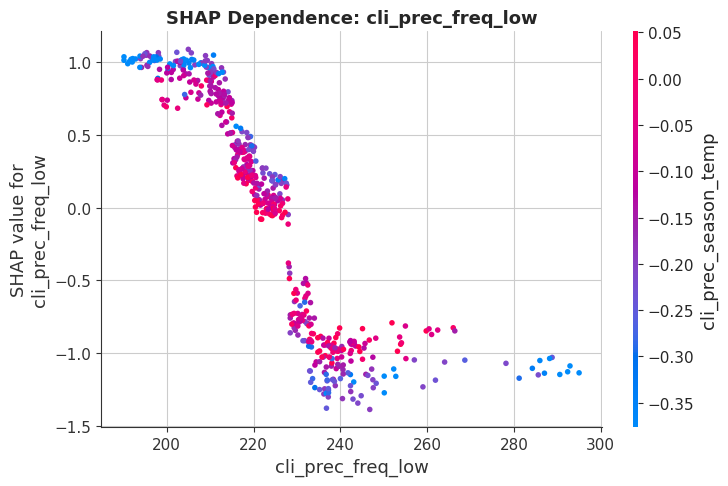

    2. cli_prec_season_temp


<Figure size 1000x600 with 0 Axes>

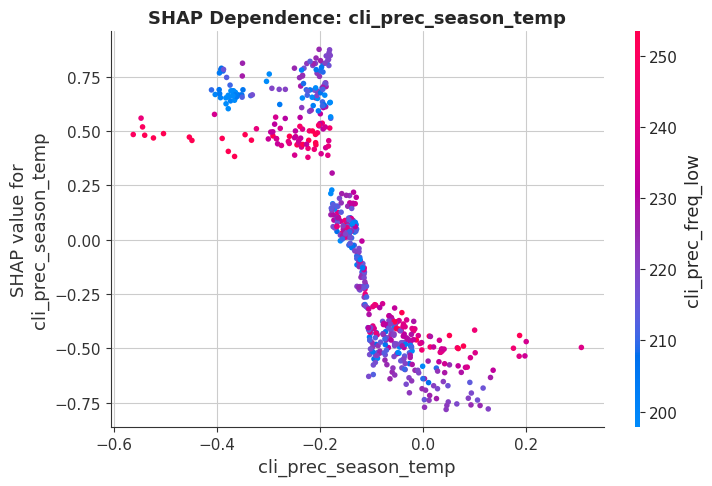

    3. cli_prec_intensity


<Figure size 1000x600 with 0 Axes>

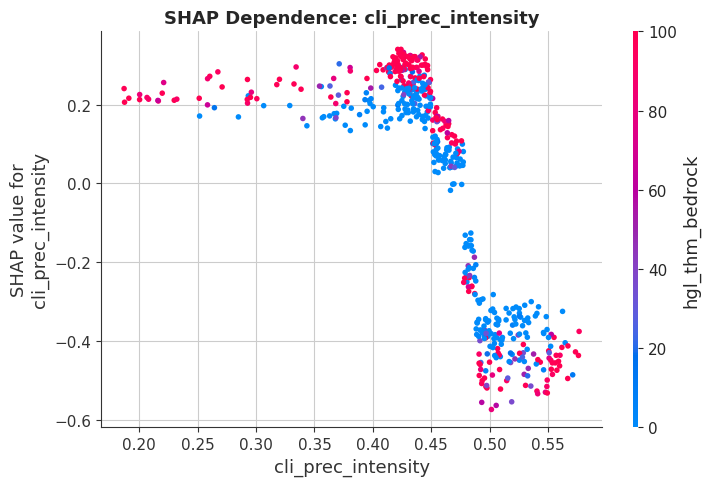

    4. hyd_hfd_mean


<Figure size 1000x600 with 0 Axes>

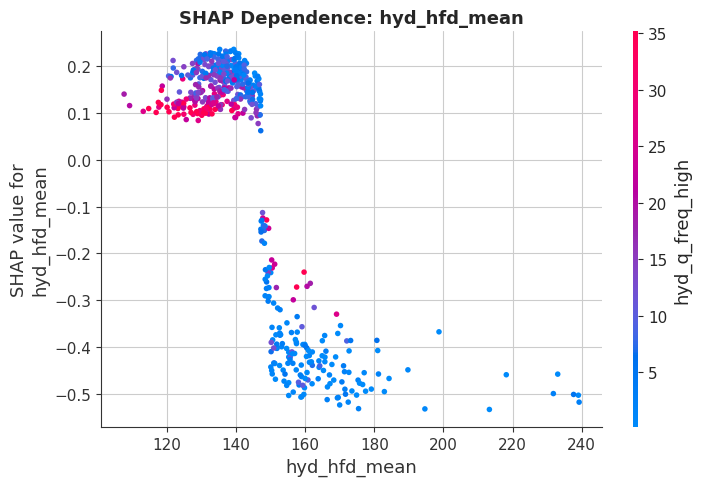

    5. cli_prec_freq_high


<Figure size 1000x600 with 0 Axes>

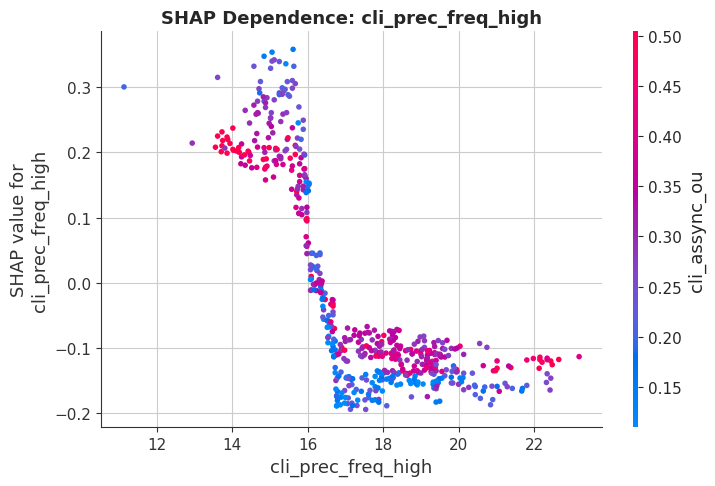

    6. hyd_bfi_ladson


<Figure size 1000x600 with 0 Axes>

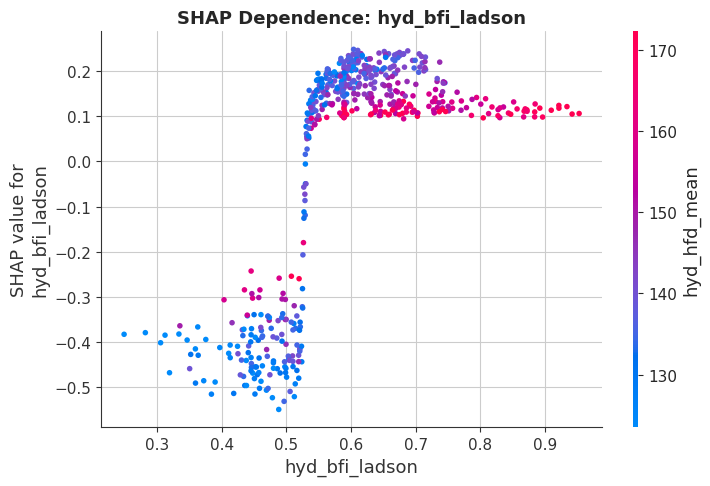

    7. top_slo_gentle


<Figure size 1000x600 with 0 Axes>

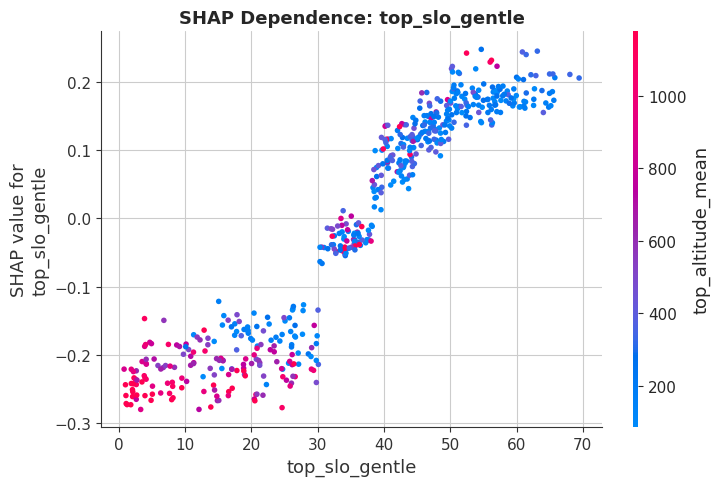

    8. cli_prec_mean


<Figure size 1000x600 with 0 Axes>

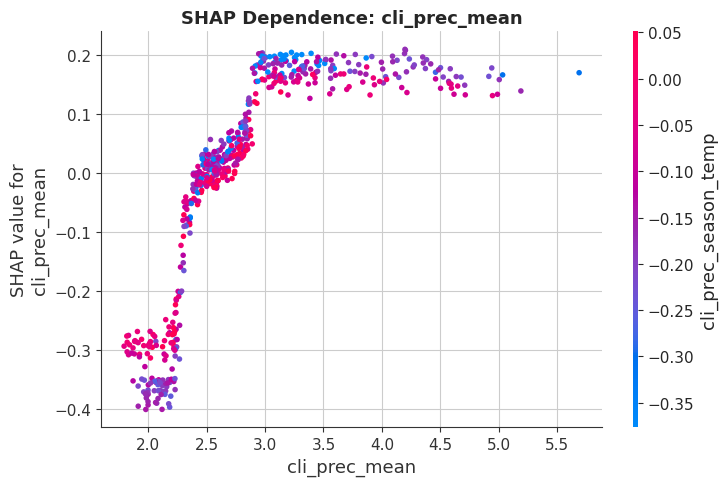

    9. hgl_thm_bedrock


<Figure size 1000x600 with 0 Axes>

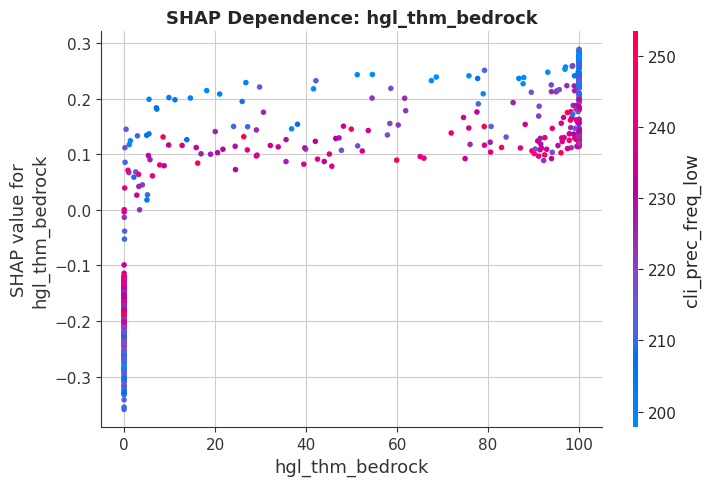

   10. cli_assync_ou


<Figure size 1000x600 with 0 Axes>

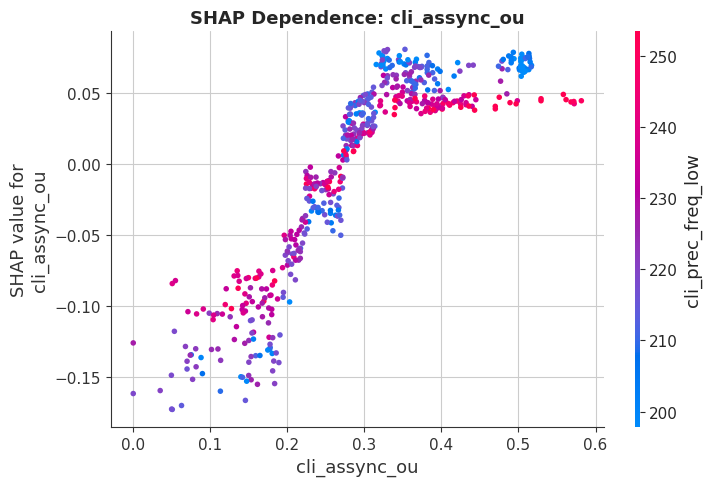

✓ Saved: SHAP_Dependence_Plots.pdf

✅ ALL VISUALIZATIONS COMPLETE

Generated files:
  1. Feature_Consensus_RF_XGB.csv
  2. SHAP_Signed_Interpretation.csv
  3. Feature_Selection_Analysis.pdf
  4. SHAP_Dependence_Plots.pdf


In [15]:
# ============================================================================
# COMPREHENSIVE VISUALIZATION FOR PAPER
# ============================================================================

print("\n" + "="*80)
print("GENERATING PUBLICATION-QUALITY PLOTS")
print("="*80)

# Set style
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

with PdfPages('Feature_Selection_Analysis.pdf') as pdf:

    # ==================================================
    # PLOT 1: Model Performance Comparison
    # ==================================================
    print("\n1. Model performance comparison...")
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # RF performance
    rf_perf_df_long = rf_perf_df.melt(
        id_vars='fold',
        value_vars=['f1', 'balanced_acc', 'recall_good'],
        var_name='Metric', value_name='Score'
    )
    sns.boxplot(data=rf_perf_df_long, x='Metric', y='Score', ax=axes[0], color='skyblue')
    axes[0].set_title('Random Forest Performance', fontweight='bold')
    axes[0].set_ylabel('Score')
    axes[0].set_ylim([0, 1])
    axes[0].set_xticklabels(['F1', 'Balanced Acc', 'Recall (Good)'])

    # XGBoost performance
    xgb_perf_df_long = xgb_perf_df.melt(
        id_vars='fold',
        value_vars=['f1', 'balanced_acc', 'recall_good'],
        var_name='Metric', value_name='Score'
    )
    sns.boxplot(data=xgb_perf_df_long, x='Metric', y='Score', ax=axes[1], color='lightcoral')
    axes[1].set_title('XGBoost Performance', fontweight='bold')
    axes[1].set_ylabel('Score')
    axes[1].set_ylim([0, 1])
    axes[1].set_xticklabels(['F1', 'Balanced Acc', 'Recall (Good)'])

    plt.tight_layout()
    pdf.savefig(dpi=300, bbox_inches='tight')
    plt.close()

    # ==================================================
    # PLOT 2: Feature Importance Comparison (Top 20)
    # ==================================================
    print("2. Feature importance comparison...")
    fig, axes = plt.subplots(1, 2, figsize=(16, 10))

    # RF top 20
    rf_top20 = rf_importance_df.head(20).sort_values('RF_SHAP_mean')
    axes[0].barh(rf_top20['Feature'], rf_top20['RF_SHAP_mean'], color='skyblue', edgecolor='black')
    axes[0].set_xlabel('Mean |SHAP| Value', fontweight='bold')
    axes[0].set_title('Random Forest - Top 20 Features', fontweight='bold', fontsize=14)
    axes[0].grid(axis='x', alpha=0.3)

    # XGBoost top 20
    xgb_top20 = xgb_importance_df.head(20).sort_values('XGB_SHAP_mean')
    axes[1].barh(xgb_top20['Feature'], xgb_top20['XGB_SHAP_mean'], color='lightcoral', edgecolor='black')
    axes[1].set_xlabel('Mean |SHAP| Value', fontweight='bold')
    axes[1].set_title('XGBoost - Top 20 Features', fontweight='bold', fontsize=14)
    axes[1].grid(axis='x', alpha=0.3)

    plt.tight_layout()
    pdf.savefig(dpi=300, bbox_inches='tight')
    plt.close()

    # ==================================================
    # PLOT 3: Consensus Features (Top 20)
    # ==================================================
    print("3. Consensus features...")
    fig, ax = plt.subplots(figsize=(12, 10))

    top20_consensus = consensus_df.head(20).sort_values('Mean_Rank', ascending=False)

    y_pos = np.arange(len(top20_consensus))
    ax.barh(y_pos, top20_consensus['Mean_Rank'], color='mediumseagreen', edgecolor='black', alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top20_consensus['Feature'])
    ax.set_xlabel('Mean Rank (Lower = Better)', fontweight='bold')
    ax.set_title(f'Top {FINAL_N} Consensus Features (RF + XGBoost)', fontweight='bold', fontsize=14)
    ax.grid(axis='x', alpha=0.3)
    ax.invert_xaxis()  # Lower ranks on right

    plt.tight_layout()
    pdf.savefig(dpi=300, bbox_inches='tight')
    plt.close()

    # ==================================================
    # PLOT 4: Directional SHAP (Signed)
    # ==================================================
    print("4. Directional SHAP interpretation...")
    fig, ax = plt.subplots(figsize=(12, 10))

    signed_sorted = signed_shap_consensus.sort_values('SHAP_Signed_Mean')

    colors = ['red' if x < 0 else 'green' for x in signed_sorted['SHAP_Signed_Mean']]
    ax.barh(signed_sorted['Feature'], signed_sorted['SHAP_Signed_Mean'], color=colors, edgecolor='black', alpha=0.7)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5)
    ax.set_xlabel('Signed SHAP Value', fontweight='bold')
    ax.set_title(f'Directional Feature Effects (Top {FINAL_N} Consensus)', fontweight='bold', fontsize=14)
    ax.text(0.02, 0.98, 'Green: Higher value → Better NSE\nRed: Higher value → Worse NSE',
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    pdf.savefig(dpi=300, bbox_inches='tight')
    plt.close()

    # ==================================================
    # PLOT 5: SHAP Summary Plot
    # ==================================================
    print("5. SHAP summary plot...")
    fig, ax = plt.subplots(figsize=(12, 10))

    # Use only consensus features
    X_consensus = X[final_features]
    shap_values_consensus = shap_values_signed[:, [X.columns.get_loc(f) for f in final_features]]

    shap.summary_plot(
        shap_values_consensus,
        X_consensus,
        plot_type='dot',
        show=False,
        max_display=FINAL_N
    )
    plt.title(f'SHAP Summary - Top {FINAL_N} Consensus Features', fontweight='bold', fontsize=14, pad=20)
    plt.tight_layout()
    pdf.savefig(dpi=300, bbox_inches='tight')
    plt.close()

print(f"\n✓ Saved: Feature_Selection_Analysis.pdf")

# ==================================================
# SHAP DEPENDENCE PLOTS (Separate PDF)
# ==================================================
print(f"\n6. SHAP dependence plots for top {min(10, FINAL_N)} features...")

with PdfPages('SHAP_Dependence_Plots.pdf') as pdf:
    for i, feature in enumerate(final_features[:10], 1):
        print(f"   {i:2d}. {feature}")

        fig = plt.figure(figsize=(10, 6))
        shap.dependence_plot(
            feature,
            shap_values_signed,
            X,
            show=False
        )
        plt.title(f'SHAP Dependence: {feature}', fontsize=13, fontweight='bold')
        plt.tight_layout()
        pdf.savefig(dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

print(f"✓ Saved: SHAP_Dependence_Plots.pdf")

print("\n" + "="*80)
print("✅ ALL VISUALIZATIONS COMPLETE")
print("="*80)
print("\nGenerated files:")
print("  1. Feature_Consensus_RF_XGB.csv")
print("  2. SHAP_Signed_Interpretation.csv")
print("  3. Feature_Selection_Analysis.pdf")
print("  4. SHAP_Dependence_Plots.pdf")